# CIFAR10 분류기 VGG16 torch 구현

In [ ]:
import numpy as np # 기본적인 연산을 위한 라이브러리
import matplotlib.pyplot as plt # 그림이나 그래프를 그리기 위한 라이브러리
from tqdm.notebook import tqdm # 상태 바를 나타내기 위한 라이브러리
import math # 수학 계산을 위한 라이브러

import torch # PyTorch 라이브러리
import torch.nn as nn # 모델 구성을 위한 라이브러리
import torch.optim as optim # optimizer 설정을 위한 라이브러리
from torch.utils.data import Dataset, DataLoader # 데이터셋 설정을 위한 라이브러리
import torch.nn.functional as F # torch에서 수학적인 function을 쉽게 불러오기 위한 라이브러리

import torchvision.transforms as T # 이미지의 다양성을 주기 위한 라이브러리
import torchvision # torch에서 이미지를 처리하기 위한 라이브러
import torchvision.utils as vutils # torch로 구성된 이미지를 쉽게 구성하기 위한 라이브러리

from sklearn.metrics import accuracy_score # 정확도 성능지표 측정

In [3]:
# seed 고정
import random
import torch.backends.cudnn as cudnn

def random_seed(seed_num):
    torch.manual_seed(seed_num)
    torch.cuda.manual_seed(seed_num)
    torch.cuda.manual_seed_all(seed_num)
    np.random.seed(seed_num)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(seed_num)

random_seed(42)

In [4]:
# Hyper parameter
patience = 3
verbose = True

device = 'cpu' # gpu 설정 -> m1은 불가능 -> cpu로 설정

# 모델 생성
- torch.nn.Module 상속
- def __init__(self)
    - super().__init__()
- def forward()

In [28]:
class VGG16(torch.nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        
        self.block1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.MaxPool2d(kernel_size=2)
        )

        self.block2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),
            torch.nn.MaxPool2d(kernel_size=2)
        )

        self.block3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(256),
            torch.nn.MaxPool2d(kernel_size=2)
        )

        self.block4 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(512),
            torch.nn.MaxPool2d(kernel_size=2)
        )

        self.block5 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(512),
            torch.nn.MaxPool2d(kernel_size=2)
        )

        self.block6 = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(512, 4096),
            torch.nn.ReLU(),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(),
            torch.nn.Linear(4096, 10)
        )

        self.softmax = nn.LogSoftmax(dim=1) # dim=1 -> 각 행에 대해서 수행하게 된다.

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.softmax(x)

        return x
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [29]:
model = VGG16()

In [30]:
model.count_parameters()

33641162

# 모델 학습

### data

In [25]:
cifar10_transform = T.Compose([
    T.ToTensor(),
])

In [13]:
# torchvision 라이브러리를 사용하여 CIFAR10 데이터 셋을 불러옵니다.
download_root = './CIFAR10_DATASET'

train_dataset = torchvision.datasets.CIFAR10(download_root, transform=cifar10_transform, train=True, download=True) # train dataset 다운로드
test_dataset = torchvision.datasets.CIFAR10(download_root, transform=cifar10_transform, train=False, download=True) # test dataset 다운로드

100%|██████████| 170498071/170498071 [01:16<00:00, 2230795.55it/s]


Extracting ./CIFAR10_DATASET/cifar-10-python.tar.gz to ./CIFAR10_DATASET
Files already downloaded and verified


In [14]:
# 데이터 셋을 학습 데이터 셋과 검증 데이터 셋으로 분리합니다.
total_size = len(train_dataset)
train_num, valid_num = int(total_size * 0.8), int(total_size * 0.2) # 8 : 2 = train : valid
print("Train dataset 개수 : ", train_num)
print("Validation dataset 개수 : ", valid_num)
print("Test dataset 개수 :", len(test_dataset))
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_num, valid_num]) # train - valid set 나누기

Train dataset 개수 :  40000
Validation dataset 개수 :  10000
Test dataset 개수 : 10000


In [15]:
# DataLoader(tensor형태의 dataset, batch_size, shuffle 유무)

batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
for images, labels in train_dataloader: # train dataset의 image shape과 label의 shape
    print(images.shape, labels)

torch.Size([32, 3, 32, 32]) tensor([0, 4, 7, 0, 0, 5, 8, 1, 5, 5, 9, 0, 9, 3, 3, 7, 3, 0, 4, 8, 4, 2, 9, 1,
        3, 2, 3, 8, 6, 3, 7, 3])
torch.Size([32, 3, 32, 32]) tensor([7, 9, 7, 5, 6, 8, 4, 1, 9, 6, 0, 5, 4, 8, 2, 0, 5, 3, 8, 8, 4, 0, 5, 3,
        5, 1, 8, 7, 4, 0, 5, 1])
torch.Size([32, 3, 32, 32]) tensor([9, 6, 4, 6, 6, 4, 1, 8, 6, 5, 5, 6, 7, 8, 6, 4, 7, 1, 8, 4, 2, 6, 7, 7,
        2, 5, 3, 5, 6, 8, 5, 1])
torch.Size([32, 3, 32, 32]) tensor([5, 1, 4, 6, 2, 8, 3, 1, 1, 9, 8, 5, 6, 8, 8, 6, 1, 2, 5, 1, 1, 7, 5, 5,
        8, 8, 4, 8, 1, 6, 3, 5])
torch.Size([32, 3, 32, 32]) tensor([6, 4, 8, 4, 6, 0, 8, 7, 2, 5, 2, 6, 0, 9, 3, 8, 6, 1, 2, 5, 8, 9, 4, 8,
        0, 4, 5, 1, 7, 2, 0, 9])
torch.Size([32, 3, 32, 32]) tensor([8, 0, 6, 9, 5, 2, 3, 5, 5, 8, 5, 5, 4, 9, 6, 5, 8, 9, 4, 5, 5, 7, 9, 5,
        4, 9, 7, 3, 8, 8, 8, 3])
torch.Size([32, 3, 32, 32]) tensor([3, 4, 4, 3, 7, 0, 3, 4, 5, 6, 9, 0, 9, 7, 6, 4, 7, 6, 0, 9, 1, 3, 2, 6,
        9, 6, 4, 6, 3, 4, 5, 6])
torch.Size([3

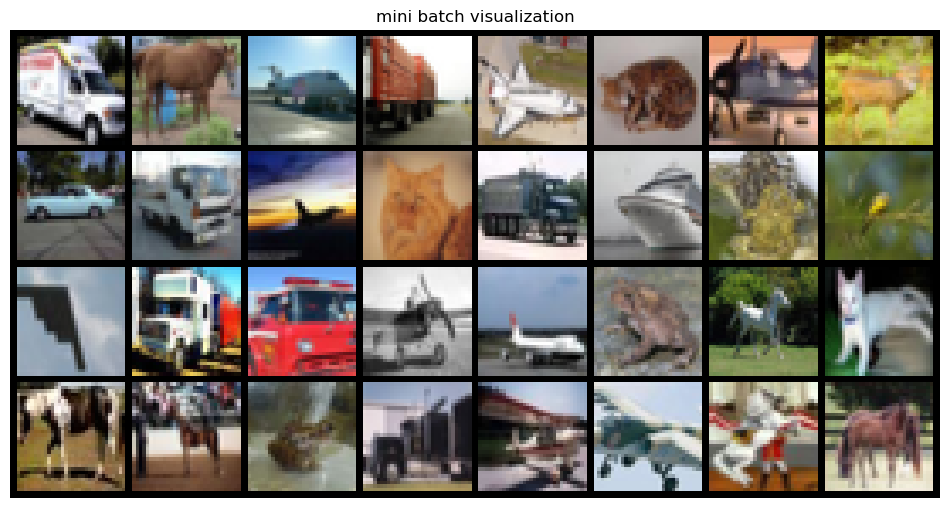

In [19]:
grid = vutils.make_grid(images, nrow=8) # 각 행마다 8개의 이미지 배치하여 격자로 구성합니다.

# 학습 데이터로더로 부터 불러온 이미지를 시각화합니다
plt.figure(figsize=(12,12))
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.title("mini batch visualization")
plt.axis('off')
plt.show()

### 모델 학습
- model.train() : 학습모드
- for images, labels in train_dataloader : 모든 데이터에 대해서 진행 (batch_size단위로 묶여서 나눠져있다)
- ouputs = model(images) : forward진행
- loss = criterion(ouputs, labels) : 현재 모델의 결과와 실제 값의 차이를 구한다.
- optimizer.zero_grad() : 기울기 초기화 -> 이전 값의 영향을 안 받기 위해
- loss.backward() : 역전파
- optimizer.step() : 가중치 업데이터

In [36]:
def training(model, train_dataloader, criterion, optimizer):
    model.train()
    cnt = 0

    for images, labels in train_dataloader:
        if (cnt + 1) % 10 == 0:
            print(cnt)
        images = images.to('cpu')
        labels = labels.to('cpu')

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        cnt += 1

    return model

In [37]:
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model = training(model, train_dataloader, criterion, optimizer)

9
19
29
39
49
59
69
79
89
99
109
119
129
139
149
159
169
179
189
199
209
219
229
239
249
259
269
279
289
299
309
319
329
339
349
359
369
379
389
399
409
419
429
439
449
459
469
479
489
499
509
519
529
539
549
559
569
579
589
599
609
619
629
639
649
659
669
679
689
699
709
719
729
739
749
759
769
779
789
799
809
819
829
839
849
859
869
879
889
899
909
919
929
939
949
959
969
979
989
999
1009
1019
1029
1039
1049
1059
1069
1079
1089
1099
1109
1119
1129
1139
1149
1159
1169
1179
1189
1199
1209
1219
1229
1239
1249


### test

In [38]:
def test(model, test_dataloader):
    model.eval()
    total_labels = []
    total_preds = []

    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to('cpu')
            labels = labels

            outputs = model(images)
            max_pob, predicted = torch.max(outputs.data, 1)

            total_preds.extend(predicted.detach().cpu().tolist())
            total_labels.extend(labels.tolist())

    total_preds = np.array(total_preds)
    total_labels = np.array(total_labels)

    return total_labels, total_preds

In [39]:
total_labels, total_preds = test(model, test_dataloader)

In [40]:
accuracy_score(total_labels, total_preds)

0.2635

In [42]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./CIFAR10_DATASET
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [41]:
total_labels

array([3, 8, 8, ..., 5, 1, 7])